In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

## Load and pre process data

In [2]:
player_data = pd.read_csv("DataCollection/Player_Stats/player_stats_2021-22.csv")

In [3]:
shooting_data = pd.read_csv("DataCollection/Player_Shooting_Stats/Regular_Season/player_shooting_stats_2021-22.csv")

In [4]:
player_data = pd.merge(player_data, shooting_data.loc[:,~shooting_data.columns.isin(['Pos', 'Age', 'G', 'MP', 'FG%'])], on=['Player', 'Tm'])

In [5]:
player_data = player_data.fillna(0)
player_data = player_data[(player_data["MP"] > 15) & (player_data["G"] >= 30)]
player_data = player_data.sort_values(by=['G'], ascending=False)
player_data = player_data[player_data["Tm"] != "TOT"]
player_data = player_data.drop_duplicates(subset ="Player",keep = "first")
player_data.reset_index(inplace=True)
player_data.drop(columns=['index'], inplace=True)

## Normalize the data

In [6]:
features = player_data.loc[:, ~player_data.columns.isin(["Player", "Pos", "Tm"])].values
x = StandardScaler().fit_transform(features)

## Reduce Dimensionality to 2 components

In [7]:
pca = PCA(n_components=2)
components = pca.fit_transform(x)

componentsDf = pd.DataFrame(data = components, columns = ['PC1', 'PC2'])
finalDf = pd.concat([componentsDf, player_data[['Pos', "Player"]]], axis = 1)

### Plot 2D PCA

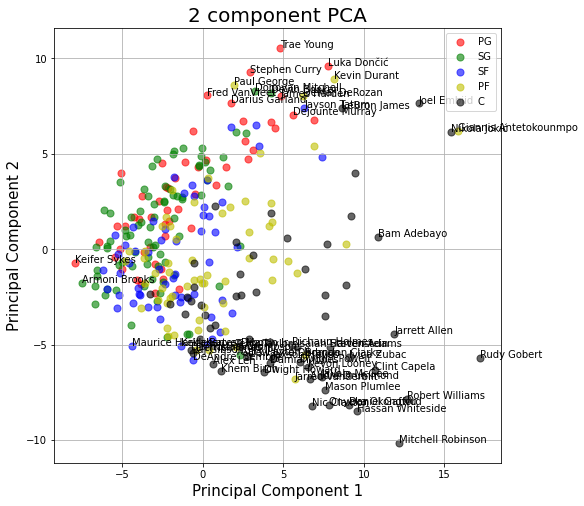

In [8]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)

targets = ['PG', 'SG', 'SF', 'PF', 'C']
colors = ['r', 'g', 'b', 'y', 'k']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['Pos'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'PC1'], finalDf.loc[indicesToKeep, 'PC2'], 
               c=color, s=50, alpha=.6)
ax.legend(targets)
ax.grid()

for i, data in finalDf.iterrows():
    if data["PC1"] < -7 or data["PC2"] > 7 or data["PC1"] > 10 or data["PC2"] < -5:
        ax.annotate(data["Player"], (data["PC1"], data["PC2"]))

# Clustering

C:\Users\140775\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


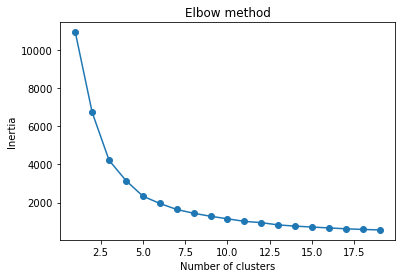

In [9]:
data = list(zip(finalDf["PC1"], finalDf["PC2"]))

inertias = []

for i in range(1,20):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(data)
    inertias.append(kmeans.inertia_)

plt.plot(range(1,20), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

## Run K-means

In [10]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(data)
cmap = plt.cm.get_cmap('Dark2', 5)
finalDf['Cluster'] = kmeans.labels_

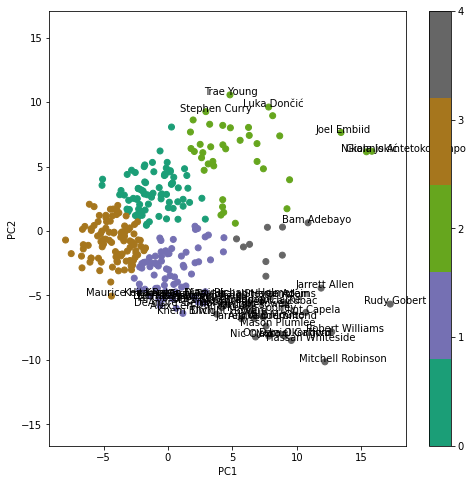

In [11]:
plt.figure(figsize=(8, 8))
plt.scatter(finalDf["PC1"], finalDf["PC2"], c=finalDf['Cluster'], cmap=cmap)
plt.xlabel("PC1")
plt.ylabel("PC2")
for i, row in finalDf.iterrows():
    if row["PC1"] < -10 or row["PC2"] > 9 or row["PC1"] > 10 or row["PC2"] < -5:
        plt.text(row["PC1"]-2, row["PC2"], row["Player"])
plt.axis('equal')
plt.colorbar(ticks=[0, 1, 2, 3, 4])
plt.show()

## Randomizing PCA features

In [36]:
def run_random_pca(df, non_feature_cols, target):
    features = df.loc[:, ~df.columns.isin(non_feature_cols)]
    random_selector = np.random.choice(a=[False, True], size=len(features.columns), p=[.5, .5])
    random_features_df = features.loc[:, random_selector]
    selected_features = list(random_features_df.columns)
    random_features = random_features_df.values        
    random_features = StandardScaler().fit_transform(random_features)
    
    if random_features.shape[1] <= 0.45 * len(features.columns):
        return None, None
    
    pca = PCA(2)
    components = pca.fit_transform(random_features)
    components_df = pd.DataFrame(data=components, columns=["PC1", "PC2"])
    components_df = pd.concat([components_df, df[target]], axis=1)
    var = pca.explained_variance_ratio_
    return components_df, [selected_features, len(selected_features), var[0], var[1], sum(var)]

In [15]:
PCAs = pd.DataFrame(columns=["Features", "Features Count", "PC1 var", "PC2 var", "Total explained variance ratio"])

In [ ]:
for i in range(10**5):
    df, pca_stats = run_random_pca(player_data, ["Player", "Pos", "Tm"], ["Player", "Pos"])
    if df is not None:
        pca_row = {'Features': ' '.join(pca_stats[0]),
                   'Features Count': pca_stats[1],
                   'PC1 var': pca_stats[2],
                   'PC2 var': pca_stats[3],
                   'Total explained variance ratio': pca_stats[4]}
        PCAs = PCAs.append(pca_row, ignore_index=True)

In [ ]:
for i in range(10**6):
    df, pca_stats = run_random_pca(player_data, ["Player", "Pos", "Tm"], ["Player", "Pos"])
    if df is not None:
        pca_row = {'Features': ' '.join(pca_stats[0]),
                   'Features Count': pca_stats[1],
                   'PC1 var': pca_stats[2],
                   'PC2 var': pca_stats[3],
                   'Total explained variance ratio': pca_stats[4]}
        PCAs = PCAs.append(pca_row, ignore_index=True)

In [ ]:
PCAs.to_csv("DataCollection/PCA/random_PCAs_playerData.csv", index=False)

In [12]:
PCAs = pd.read_csv("DataCollection/PCA/random_PCAs_playerData.csv")

In [13]:
PCAs.sort_values(by='Total explained variance ratio', ascending=False, inplace=True)

In [14]:
features = player_data[PCAs.iloc[1]['Features'].split()] 
x = StandardScaler().fit_transform(features)
pca = PCA(n_components=2)
components = pca.fit_transform(x)

componentsDf = pd.DataFrame(data = components, columns = ['PC1', 'PC2'])
df = pd.concat([componentsDf, player_data[['Pos', "Player"]]], axis = 1)

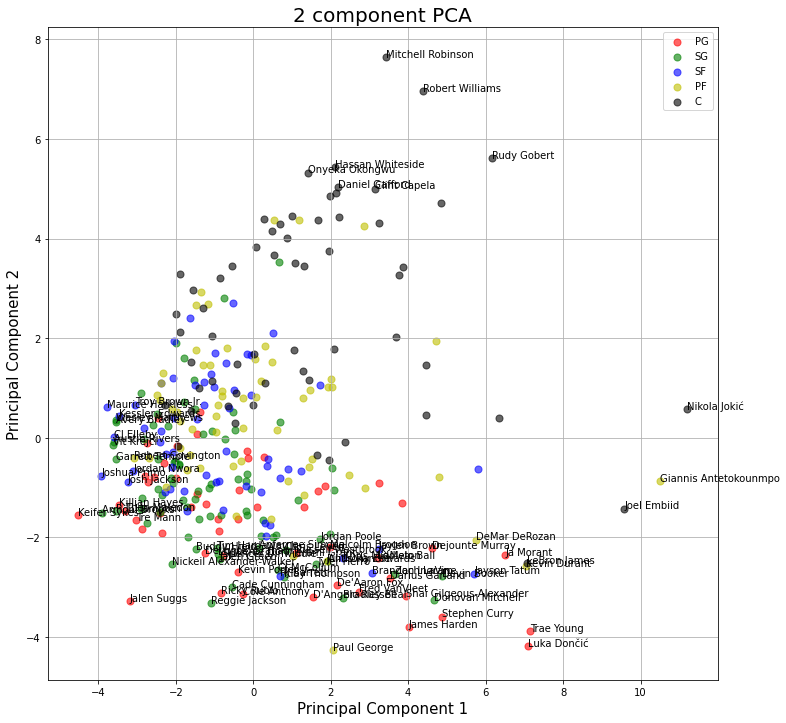

In [15]:
fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)

targets = ['PG', 'SG', 'SF', 'PF', 'C']
colors = ['r', 'g', 'b', 'y', 'k']
for target, color in zip(targets,colors):
    indicesToKeep = df['Pos'] == target
    ax.scatter(df.loc[indicesToKeep, 'PC1'], df.loc[indicesToKeep, 'PC2'], 
               c=color, s=50, alpha=.6)
ax.legend(targets)
ax.grid()

for i, data in df.iterrows():
    if data["PC1"] < -3 or data["PC2"] > 5 or data["PC1"] > 7.5 or data["PC2"] < -2:
        ax.annotate(data["Player"], (data["PC1"], data["PC2"]))

C:\Users\140775\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


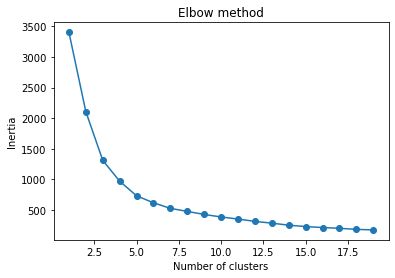

In [16]:
data = list(zip(df["PC1"], df["PC2"]))

inertias = []

for i in range(1,20):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(data)
    inertias.append(kmeans.inertia_)

plt.plot(range(1,20), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [17]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(data)
cmap = plt.cm.get_cmap('Dark2', 5)
df['Cluster'] = kmeans.labels_

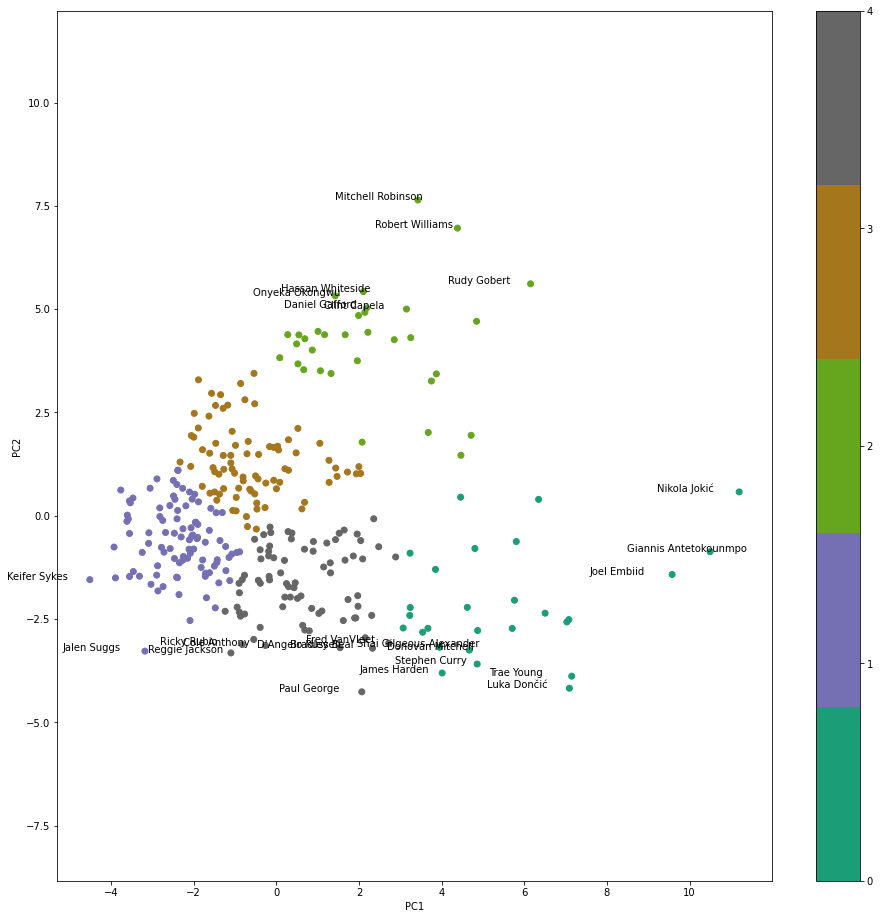

In [26]:
plt.figure(figsize=(16, 16))
plt.scatter(df["PC1"], df["PC2"], c=df['Cluster'], cmap=cmap)
plt.xlabel("PC1")
plt.ylabel("PC2")
for i, row in df.iterrows():
    if row["PC1"] < -4 or row["PC2"] > 5 or row["PC1"] > 7.5 or row["PC2"] < -3:
        plt.text(row["PC1"]-2, row["PC2"], row["Player"])
plt.axis('equal')
plt.colorbar(ticks=[0, 1, 2, 3, 4])
plt.show()

In [22]:
pd.set_option('display.max_rows', None)

In [25]:
df.sort_values('Cluster')

,PC1,PC2,Pos,Player,Cluster
201,3.948062,-3.183987,PG,Shai Gilgeous-Alexander,0
146,7.090703,-4.173553,PG,Luka Dončić,0
144,3.849834,-1.298545,PG,Chris Paul,0
114,4.802810,-0.792737,PF,Pascal Siakam,0
58,11.198252,0.576626,C,Nikola Jokić,0
140,3.238715,-2.220971,SF,Jaylen Brown,0
32,5.760763,-2.044497,PF,DeMar DeRozan,0
206,7.077399,-2.513638,C,LeBron James,0
208,7.028092,-2.570467,PF,Kevin Durant,0
115,4.870192,-2.777778,SG,Devin Booker,0
